# Solar Forecast with LSTM
# Model Data: 60 minutes

In [1]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.metrics import classification_report

In [2]:
working_dir = '/Volumes/Samsung_T5/WeatherNet_V2/TowerDataTest/60_min_test'

## Make train generator

In [3]:
train_df = pd.read_csv(working_dir+"/train_weather.csv")
train_df.index = train_df['Unnamed: 0'].values
train_df.drop(['Unnamed: 0'],axis=1,inplace=True)
print(train_df.shape)
train_df.head()

(13838, 152)


,Average 60 m temperature,Average 60 m wind speed,Vector-averaged 60 m wind speed,Vector-averaged 60 m wind direction,Standard deviation of 60 m wind direction,Total precipitaion for the period,Estimated heat flux,Estimated friction velocity,Average 10 m temperature,Average 10 m wind speed,...,day_month_22,day_month_23,day_month_24,day_month_25,day_month_26,day_month_27,day_month_28,day_month_29,day_month_30,day_month_31
2020_01_01_00_15,0.000170,0.005553,0.005741,0.002639,0.000084,0.0,0.191211,0.035361,0.000173,0.004179,...,0,0,0,0,0,0,0,0,0,0
2020_01_01_00_30,0.000169,0.005937,0.006131,0.002634,0.000078,0.0,0.191211,0.039050,0.000172,0.004428,...,0,0,0,0,0,0,0,0,0,0
2020_01_01_00_45,0.000168,0.006132,0.006330,0.002635,0.000075,0.0,0.191211,0.044746,0.000171,0.004404,...,0,0,0,0,0,0,0,0,0,0
2020_01_01_01_00,0.000166,0.005678,0.005872,0.002629,0.000080,0.0,0.191211,0.040469,0.000169,0.004113,...,0,0,0,0,0,0,0,0,0,0
2020_01_01_01_15,0.000165,0.005300,0.005506,0.002627,0.000074,0.0,0.191211,0.030821,0.000168,0.004074,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_df['p_target_4'].head(5)

2020_01_01_00_15    0
2020_01_01_00_30    0
2020_01_01_00_45    0
2020_01_01_01_00    0
2020_01_01_01_15    0
Name: p_target_4, dtype: int64

In [5]:
y_train = train_df["p_target_4"].values
y_train_hot = np.zeros((y_train.size, y_train.max()+1))
y_train_hot[np.arange(y_train.size),y_train] = 1

train_df.drop(['p_target_4'],axis=1,inplace=True)
X_train = train_df.values
print(X_train.shape)

(13838, 151)


In [6]:
time_steps = 4
train_gen = TimeseriesGenerator(X_train, y_train_hot,length=time_steps,batch_size=16)
print(len(train_gen))

865


In [7]:
# test generator to have corresponding labels
batch_0 = train_gen[0]
x, y = batch_0

print(x.shape)
print(y.shape)

(16, 4, 151)
(16, 3)


## Declare Model

In [8]:
i = Input(shape=(time_steps,X_train.shape[1]))

x = LSTM(64,kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4),\
    bias_regularizer=regularizers.l2(1e-4),\
        recurrent_dropout=0.15,dropout=.15,return_sequences=True)(i)
x = LayerNormalization()(x)
x = LSTM(32,kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4),\
    bias_regularizer=regularizers.l2(1e-4),\
        recurrent_dropout=0.15,dropout=.15,return_sequences=False)(x)
x = Dropout(.2)(x)
x = LayerNormalization()(x)
y = Dense(3,activation="softmax",kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4),\
    bias_regularizer=regularizers.l2(1e-4))(x)
    
model = Model(i, y) 
opt = Adam(.0001)
model.compile(loss='categorical_crossentropy',metrics=["acc"], optimizer=opt)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 151)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 4, 64)             55296     
_________________________________________________________________
layer_normalization (LayerNo (None, 4, 64)             128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
layer_normalization_1 (Layer (None, 32)                64        
_________________________________________________________________
dense (Dense)                (None, 3)                 99    

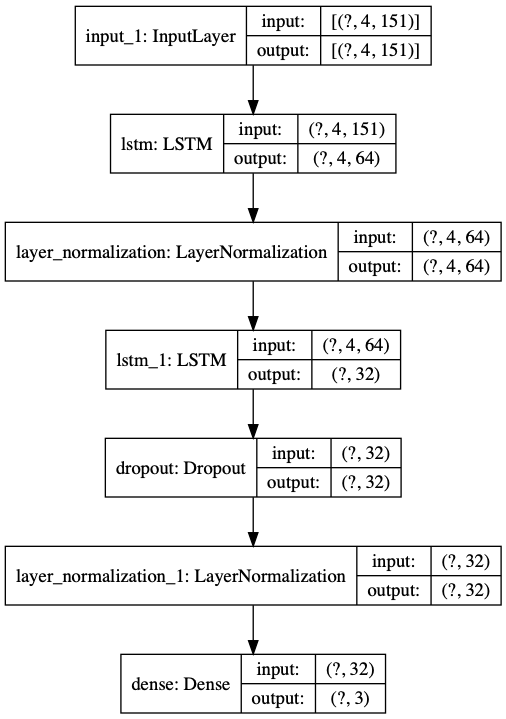

In [9]:
tf.keras.utils.plot_model(
    model,
    to_file="LSTM_Solar_Forecast_Model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [10]:
model.fit(train_gen, epochs=20,verbose=2)

  ...
    to  
  ['...']
Train for 865 steps
Epoch 1/20
865/865 - 11s - loss: 1.3507 - acc: 0.5299
Epoch 2/20
865/865 - 7s - loss: 1.0387 - acc: 0.6818
Epoch 3/20
865/865 - 7s - loss: 0.8831 - acc: 0.7471
Epoch 4/20
865/865 - 7s - loss: 0.7957 - acc: 0.7733
Epoch 5/20
865/865 - 7s - loss: 0.7519 - acc: 0.7873
Epoch 6/20
865/865 - 7s - loss: 0.7059 - acc: 0.7980
Epoch 7/20
865/865 - 7s - loss: 0.6767 - acc: 0.8047
Epoch 8/20
865/865 - 7s - loss: 0.6400 - acc: 0.8182
Epoch 9/20
865/865 - 7s - loss: 0.6352 - acc: 0.8183
Epoch 10/20
865/865 - 7s - loss: 0.6193 - acc: 0.8218
Epoch 11/20
865/865 - 7s - loss: 0.5997 - acc: 0.8277
Epoch 12/20
865/865 - 7s - loss: 0.5888 - acc: 0.8298
Epoch 13/20
865/865 - 7s - loss: 0.5804 - acc: 0.8274
Epoch 14/20
865/865 - 7s - loss: 0.5625 - acc: 0.8359
Epoch 15/20
865/865 - 7s - loss: 0.5630 - acc: 0.8319
Epoch 16/20
865/865 - 8s - loss: 0.5494 - acc: 0.8391
Epoch 17/20
865/865 - 8s - loss: 0.5379 - acc: 0.8462
Epoch 18/20
865/865 - 7s - loss: 0.5333 - acc

In [11]:
model.save("LSTM_Weather_Model.h5")

## Test Model

In [12]:
test_df = pd.read_csv(working_dir+"/test_weather.csv")
test_df.index = test_df['Unnamed: 0'].values
test_df.drop(['Unnamed: 0'],axis=1,inplace=True)

y_test = test_df["p_target_4"].values
y_test_hot = np.zeros((y_test.size, y_test.max()+1))
y_test_hot[np.arange(y_test.size),y_test] = 1

test_df.drop(['p_target_4'],axis=1,inplace=True)
X_test = test_df.values

test_gen = TimeseriesGenerator(X_test, y_test_hot,length=time_steps, batch_size=2)

In [13]:
yh = model.predict(test_gen)

target_names = ['low', 'mid', 'high']
print(classification_report(y_test[:yh.shape[0]], np.argmax(yh,axis=1), target_names=target_names))

              precision    recall  f1-score   support

         low       0.86      0.80      0.83       249
         mid       0.46      0.59      0.52       106
        high       0.94      0.90      0.92       391

    accuracy                           0.82       746
   macro avg       0.75      0.77      0.76       746
weighted avg       0.84      0.82      0.83       746

